## Index
1. [Overview](#Overview)
2. [PCA plot of the log transformed raw expression data](#PCA-plot-of-the-log-transformed-raw-expression-data)
3. [Boxplot of log2 intensities for the raw data](#Boxplot-of-log2-intensities-for-the-raw-data)
4. [Background-adjustment, normalization, summarization](#Background-adjustment,-normalization,-summarization)
5. [PCA plot of the calibrated, summarized on exon level data](#PCA-plot-of-the-calibrated,-summarized-on-exon-level-data)
6. [tSNE plot of the calibrated, summarized on exon level data](#tSNE-plot-of-the-calibrated,-summarized-on-exon-level-data)
7. [Histogram of the median intensities](#Histogram-of-the-median-intensities)
8. [Probe-based annotation for MTA 1.0](#Probe-based-annotation-for-MTA-1.0)
9. [Contrasts and hypothesis testing using `limma`](#Contrasts-and-hypothesis-testing-using-limma)
10. [Transcript-based annotation for-MTA 1.0](#Transcript-based-annotation-for-MTA-1.0)
11. [Contrasts and hypothesis testing for transcripts using `limma`](#Contrasts-and-hypothesis-testing-for-transcripts-using-limma)
12. [Volcano plot of differentially expressed genes](#Volcano-plot-of-differentially-expressed-genes)
13. [Distrubution of expression values](#Distrubution-of-expression-values)
14. [Heatmap](#Heatmap)
15. [DE genes for background matching](#DE-genes-for-background-matching)
16. [Enrichment analysis](#Enrichment-analysis)

## Overview

Pipeline for this analysis is following:  
CEL files → Bioconductor ExpressionSet → QC → Normalization → Differential gene expression analysis → Enrichment analysis

#### Description of GeneChip® Mouse Exon 1.0 ST Array (Mouse Transcriptome Assay 1.0)
>With approximately four probes per exon and roughly 40 probes per gene, the GeneChip® Mouse Exon 1.0 ST Array enables two complementary levels of analysis—gene expression and alternative splicing.
Multiple probes per exon enable "exon-level" analysis and allow you to distinguish between different isoforms of a gene. This exon-level analysis on a whole-genome scale opens the door to detecting specific alterations in exon usage that may play a central role in disease mechanism and etiology.
The second level is "gene-level" expression analysis, in which multiple probes on different exons are summarized into an expression value of all transcripts from the same gene.
Exon arrays provide the most comprehensive coverage of the genome, including empirically supported and predicted transcribed sequences, enabling the discovery of previously unidentified novel events.

In [1]:
suppressMessages({
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install()
BiocManager::install("mouse4302.db")
BiocManager::install("oligo")

install.packages("devtools")
library(devtools)
install.packages("plotly")
install.packages("Rtsne")
library(remotes)

install_github("wjawaid/enrichR")
install_github("r-lib/remotes")

library(matrixStats)
library(mta10transcriptcluster.db)
library(oligo)
library(limma)
library(genefilter)
library(dplyr)
library(magrittr)
library(stringr)
library(ggplot2)
library(plotly)
library(geneplotter)
library(RColorBrewer)
library(pheatmap)
library(Rtsne)
library(enrichR)
})


The downloaded binary packages are in
	/var/folders/hd/_qjx3t756vvb02_wx55jwqc40000gn/T//RtmpeTYnCI/downloaded_packages

The downloaded binary packages are in
	/var/folders/hd/_qjx3t756vvb02_wx55jwqc40000gn/T//RtmpeTYnCI/downloaded_packages

The downloaded binary packages are in
	/var/folders/hd/_qjx3t756vvb02_wx55jwqc40000gn/T//RtmpeTYnCI/downloaded_packages

The downloaded binary packages are in
	/var/folders/hd/_qjx3t756vvb02_wx55jwqc40000gn/T//RtmpeTYnCI/downloaded_packages


In [2]:
setwd("CEL_files")
cel_files<-list.celfiles()

SDRF <- read.delim("DH5881.sdrf.txt")
rownames(SDRF) <- SDRF$Array.Data.File
SDRF <- AnnotatedDataFrame(SDRF)

raw_data <- oligo::read.celfiles(filenames = file.path(".", SDRF$Array.Data.File), verbose = FALSE, phenoData = SDRF)
head(Biobase::pData(raw_data))

Reading in : ./DH5881-CLMD_Mo-8.1.CEL
Reading in : ./DH5881-CLMD_Mo-8.2.CEL
Reading in : ./DH5881-CLMD_Mo-8.3.CEL
Reading in : ./DH5881-CLMD_Mo-8.4.CEL
Reading in : ./DH5881-CLMD_Mo-8.5.CEL
Reading in : ./DH5881-CLMD_Mo-8.6.CEL
Reading in : ./DH5881-CLMD_Mo-8.7.CEL
Reading in : ./DH5881-CLMD_Mo-8.8.CEL


Warning message in oligo::read.celfiles(filenames = file.path(".", SDRF$Array.Data.File), :
“'channel' automatically added to varMetadata in phenoData.”

,Source.Name,Individual,Organism,Phenotype,Array.Data.File,X
,<fct>,<dbl>,<fct>,<fct>,<fct>,<lgl>
DH5881-CLMD_Mo-8.1.CEL,C1 RNA d8,8.1,Mus musculus,control,DH5881-CLMD_Mo-8.1.CEL,NA
DH5881-CLMD_Mo-8.2.CEL,C2 RNA d8,8.2,Mus musculus,control,DH5881-CLMD_Mo-8.2.CEL,NA
DH5881-CLMD_Mo-8.3.CEL,C3 RNA d8,8.3,Mus musculus,control,DH5881-CLMD_Mo-8.3.CEL,NA
DH5881-CLMD_Mo-8.4.CEL,C4 RNA d8,8.4,Mus musculus,control,DH5881-CLMD_Mo-8.4.CEL,NA
DH5881-CLMD_Mo-8.5.CEL,HL1 RNA d8,8.5,Mus musculus,helpless,DH5881-CLMD_Mo-8.5.CEL,NA
DH5881-CLMD_Mo-8.6.CEL,HL2 RNA d8,8.6,Mus musculus,helpless,DH5881-CLMD_Mo-8.6.CEL,NA


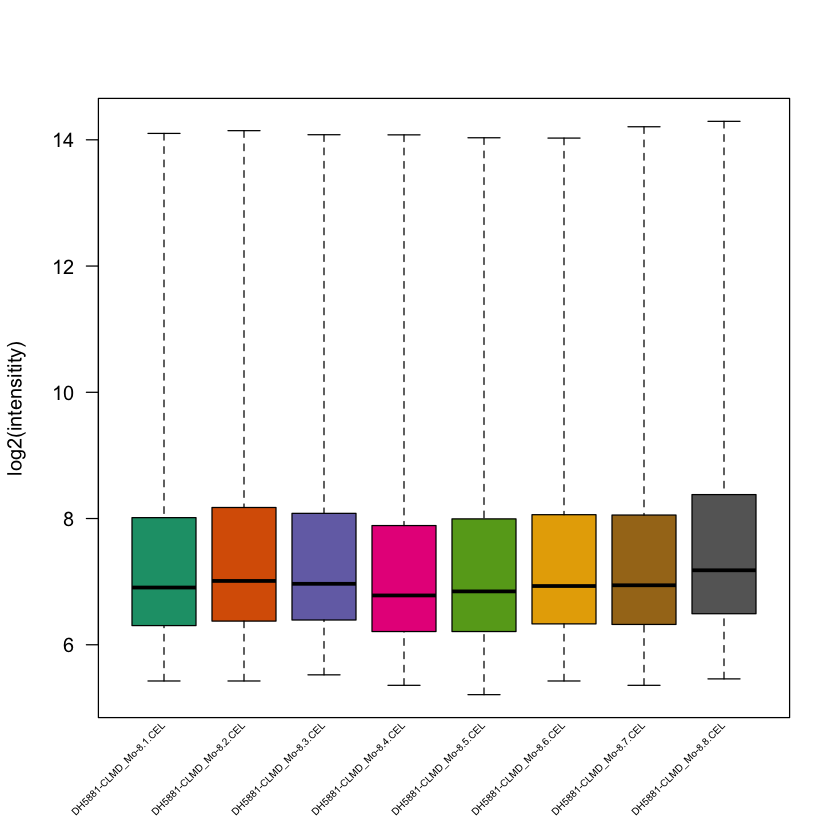

In [3]:
oligo::boxplot(raw_data, target = "core",
               ylab="log2(intensitity)",
               xlab=element_blank(),
               las=2,
               main=element_blank(),
               xaxt="n")
end_point = 0.5 + nrow(Biobase::pData(raw_data))
text(seq(1,end_point,by=1), par("usr")[3]-0.1, 
     srt = 45, adj= 1, xpd = TRUE,
     labels = paste(rownames(Biobase::pData(raw_data))), cex=0.5)

## Background normalization

In [4]:
cel_norm <- oligo::rma(raw_data, target = "core")

Background correcting
Normalizing
Calculating Expression


## PCA plot

In [5]:
exp_cel <- Biobase::exprs(cel_norm)
PCA <- prcomp(t(exp_cel), scale = FALSE)
PCA$x

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
DH5881-CLMD_Mo-8.1.CEL,-14.619115,3.456285,-16.385319,15.2275020,2.564145,-20.9167227,2.881102,2.050640e-13
DH5881-CLMD_Mo-8.2.CEL,-8.824386,-18.359816,-19.480350,-0.3166602,-14.195272,14.9014810,-5.534183,7.542252e-14
DH5881-CLMD_Mo-8.3.CEL,-24.128670,16.295578,-3.420756,-19.7360902,15.372561,3.6728344,-7.275554,5.118898e-15
DH5881-CLMD_Mo-8.4.CEL,-31.783584,-9.330038,25.402265,5.8335863,-6.499922,0.8670842,5.034746,1.935850e-13
DH5881-CLMD_Mo-8.5.CEL,19.743663,-13.212597,2.169585,12.8503817,22.082163,10.1901269,3.932993,1.214269e-13
DH5881-CLMD_Mo-8.6.CEL,19.875575,22.886823,8.205886,10.9525095,-8.365909,1.9379694,-17.290959,-1.021722e-13
DH5881-CLMD_Mo-8.7.CEL,24.343047,-20.351210,5.972639,-17.9276816,-2.735090,-14.9541651,-4.155182,-5.193764e-14
DH5881-CLMD_Mo-8.8.CEL,15.393470,18.614975,-2.463950,-6.8835476,-8.222676,4.3013919,22.407038,-1.335186e-13


## tSNE plot

In [12]:
tsne <- Rtsne(PCA$x, dims = 3, perplexity=2, verbose=TRUE, max_iter = 500)

Performing PCA
Read the 8 x 8 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 3, perplexity = 2.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.00 seconds (sparsity = 0.843750)!
Learning embedding...
Iteration 50: error is 57.696774 (50 iterations in 0.00 seconds)
Iteration 100: error is 50.397478 (50 iterations in 0.00 seconds)
Iteration 150: error is 56.089528 (50 iterations in 0.00 seconds)
Iteration 200: error is 62.949518 (50 iterations in 0.00 seconds)
Iteration 250: error is 72.668173 (50 iterations in 0.00 seconds)
Iteration 300: error is 0.781799 (50 iterations in 0.00 seconds)
Iteration 350: error is 0.073092 (50 iterations in 0.00 seconds)
Iteration 400: error is 0.061128 (50 iterations in 0.00 seconds)
Iteration 450: error is 0.054093 (50 iterations in 0.00 seconds)
Iteration 500: error is 0.052939 (50 iterations in 0.00 seconds)
Fitting performed in 0.01 seconds.


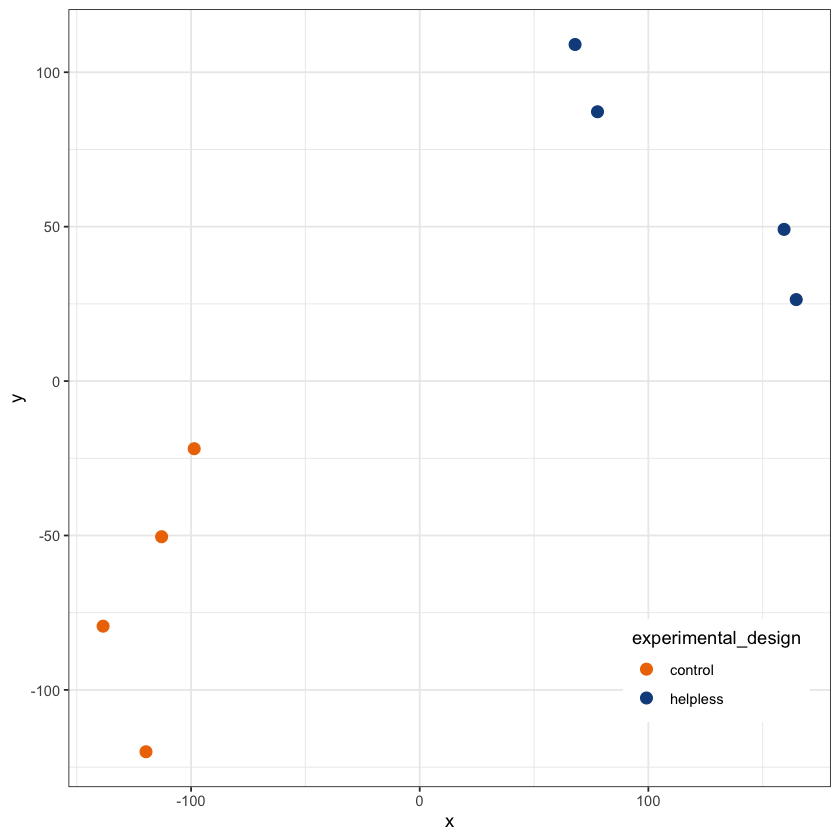

In [15]:
experimental_design <- c(rep("control", 4), rep("helpless", 4))
tsne_plot <- data.frame(x = tsne$Y[,1], y = tsne$Y[,2], sample=experimental_design)
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(tsne_plot) + geom_point(aes(x=x, y=y, color=experimental_design), size=3) +
    theme_bw() +
    theme(legend.position = c(0.85, 0.15)) + 
    scale_color_manual(values = c("darkorange2", "dodgerblue4"))

## Histogram of the median intensities

Affymetrics microarrays shows a lot of probes within background intensity range. These probes signal is not noise per se, but it doesn't provide any useful information, so `limma` recommends intensity-based filtering.
So we'll filter out low intensity low variability probes that are consistent in these features across microarrays.

To see these probes, we'll plot a histogram of median intensities.

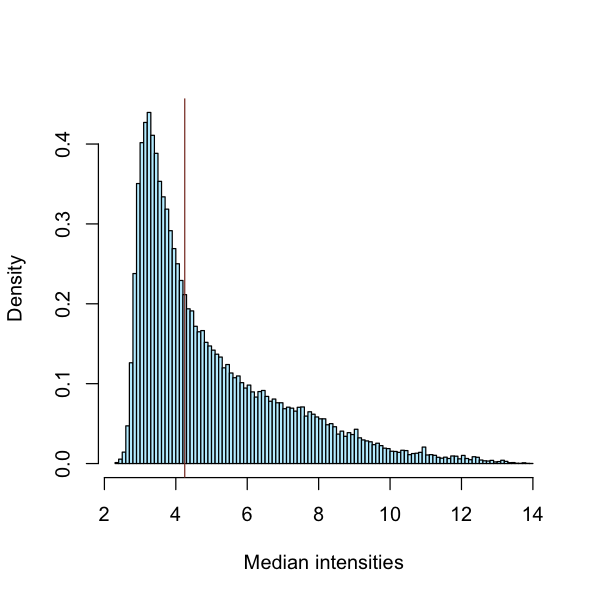

In [16]:
man_threshold <- 4.25
cel_medians <- rowMedians(Biobase::exprs(cel_norm))
options(repr.plot.width = 5, repr.plot.height = 5)
hist_res <- hist(cel_medians, 100, col = "lightblue1", freq = FALSE, 
            main = element_blank(),
            xlab = "Median intensities")

abline(v = man_threshold, col = "coral4", lwd = 1)

In [18]:
no_of_samples <- table(paste0(pData(cel_norm)$Phenotype))
no_of_samples 


 control helpless 
       4        4 

In [ ]:
samples_cutoff <- min(no_of_samples)
idx_threshold <- apply(Biobase::exprs(cel_norm), 1,
                           function(x){
                          sum(x > man_threshold) >= samples_cutoff})
table(idx_threshold)
cel_filtered <- subset(cel_norm, idx_threshold)

## Transcription-based annotation for MTA 1.0

In [19]:
anno_cel <- AnnotationDbi::select(mta10transcriptcluster.db,
                                  keys = (featureNames(cel_filtered)),
                                  columns = c("SYMBOL", "REFSEQ"),
                                  keytype = "PROBEID")
anno_cel <- subset(anno_cel, !is.na(SYMBOL))
anno_grouped <- group_by(anno_cel, PROBEID)
anno_summarized <- dplyr::summarize(anno_grouped, no_of_matches = n_distinct(SYMBOL))
anno_filtered <- filter(anno_summarized, no_of_matches > 1)
probe_stats <- anno_filtered
dim(probe_stats)

ERROR: Error in AnnotationDbi::select(mta10probeset.db, keys = (featureNames(cel_manfiltered)), : object 'mta10probeset.db' not found


In [ ]:
ids_to_exlude <- (featureNames(cel_filtered) %in% probe_stats$PROBEID)
table(ids_to_exlude)

In [ ]:
cel_final <- subset(cel_filtered, !ids_to_exlude)

In [ ]:
fData(cel_final)$PROBEID <- rownames(fData(cel_final))
fData(cel_final) <- left_join(fData(cel_final), anno_cel)
rownames(fData(cel_final)) <- fData(cel_final)$PROBEID

## Heatmap of 100 most variable genes

Split expression table to the expression values table and the gene name vector

In [ ]:
heat_cel <- as.data.frame(cbind(fData(cel_final), as.matrix(cel_final)))
heat_cel <- na.omit(heat_cel[,!names(heat_cel) %in% c("PROBEID", "GENENAME")])

Remove duplicates Select  probesets with highest average expression 

In [ ]:
heat_cel <- heat_cel[order(rowMeans(heat_cel[,-1]), decreasing = TRUE),]
dup_genes <- duplicated(heat_cel$SYMBOL)
heat_cel.unique <- heat_cel[!dup_genes,]

Take top 100 most variable genes

In [ ]:
# Order probes by variance
top_var_genes <- head(order(rowVars(heat_cel.unique[,-1]), decreasing = TRUE), 50)
heat_cel.unique_100 <- heat_cel.unique[top_var_genes, ]
# Subtract means
heat_cel.unique_100[,-1] <- heat_cel.unique_100[,-1] - rowMeans(heat_cel.unique_100[,-1])
rownames(heat_cel.unique_100) <- heat_cel.unique_100$SYMBOL
heat_cel.unique_100 <- heat_cel.unique_100[,!names(heat_cel) %in% c("SYMBOL")]

Annotate samples

In [ ]:
day_post_infection <- Biobase::pData(cel_final)$day_post_infection
day_post_infection <- ifelse(day_post_infection == "8", "d8", "d46")

treatment <- str_replace_all(Biobase::pData(cel_final)$treatment, " ", "_")
treatment <- ifelse(treatment == "ex_vivo", "ev", "h3")

ann_column <- cbind.data.frame(day_post_infection, treatment)
rownames(ann_column) <- colnames(heat_cel.unique_100)
ann_colors <- list(day_post_infection = c(d8 = "#b4e7ce", d46 = "#59a96a"), treatment = c(h3 = "#87bcde", ev = "#f2f3ae"))

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 12)
pheatmap(heat_cel.unique_100,
         annotation_col=ann_column,
         annotation_colors=ann_colors,
         treeheight_row = 0,
         cutree_cols = 2,
         border_color = NA,
         legend_breaks = c(min(heat_cel.unique_100), max(heat_cel.unique_100)),
         legend_labels = (c("down-regulated", "up-regulated")))

## DE analysis using `limma`

(Manually) Describe experimental design and save it in design matrices

In [ ]:
sample <- str_replace_all(as.character(Biobase::pData(cel_final)$file), ".CEL", "")

In [ ]:
i_8d <- sample[day_post_infection == "d8"]
design_cel_8d <- model.matrix(~ 0 + treatment[day_post_infection == "d8"])
colnames(design_cel_8d)[1:2] <- c("ev", "h3")
rownames(design_cel_8d) <- i_8d 

i_46d <- sample[day_post_infection == "d46"]
design_cel_46d <- model.matrix(~ 0 + treatment[day_post_infection == "d46"])
colnames(design_cel_46d)[1:2] <- c("ev", "h3")
rownames(design_cel_46d) <- i_46d 

[GeneChip® Mouse Expression Set 430 FAQ](https://www.affymetrix.com/support/help/faqs/mouse_430/faq_8.affx) describes how and why in Affymetrix microarrays each gene is referenced by multiple probes. However, Affymetrix does not describe a proper way to interpret ambiguity in probe-gene relation. Thus exist various 'schools' of discarding/merging probes related to the same gene name - use most significant probes, probes with the highest variability, probes with the highest expression. Some approaches advise to BLAST probe sequences and discard the ones that match up with sense strand or introns or genomic regions that do not correspond to any cDNA We'll use probes with the highest expression.

#### Creating contrast matrix

In [ ]:
contrast_matrix_8d <- makeContrasts(h3-ev, levels = design_cel_8d)

#### Apply `limma`

In [ ]:
cel_fit_8d <- eBayes(contrasts.fit(lmFit(cel_final[,day_post_infection == "d8"],
                                design = design_cel_8d),
                                contrast_matrix_8d))

#### Select probesets with highest average expression for differential gene

In [ ]:
o_8d <- order(cel_fit_8d$Amean, decreasing=TRUE)
dup_8d <- duplicated(cel_fit_8d$genes$SYMBOL[o_8d])
cel_fit_8d.unique <- cel_fit_8d[o_8d,][!dup_8d,]

#### Write results to a `.tsv` file

In [ ]:
table_8d <- topTable(cel_fit_8d.unique, number = Inf)
write.table(table_8d[order(table_8d$P.Value),], file="../control_vs_helpless_transcript.tsv", sep="\t", row.names=FALSE)

## Volcano plot of differentially expressed genes

In [ ]:
nrow(subset(table_8d, abs(logFC) > 2 & adj.P.Val < 0.1))

In [ ]:
vol_table <- subset(na.omit(table_8d), P.Value < 0.05)[c("SYMBOL", "logFC", "P.Value", "adj.P.Val")]
dim(vol_table)

In [ ]:
vol_table["group"] <- "NotSignificant"
vol_table[which(vol_table["adj.P.Val"] < 0.05 & abs(vol_table["logFC"]) < 2 ),"group"] <- "Significant"

# change the grouping for the entries a large enough logFC change but not a low enough p value
vol_table[which(vol_table["adj.P.Val"] > 0.05 & abs(vol_table["logFC"]) > 2),"group"] <- "logFC"

# change the grouping for the entries with both significance and large enough logfC change
vol_table[which(vol_table["adj.P.Val"] < 0.05 & abs(vol_table["logFC"]) > 2),"group"] <- "Significant & logFC"

In [ ]:
peaks <- vol_table[with(vol_table, order(logFC, adj.P.Val)),][1:10,]
peaks <- rbind(peaks, vol_table[with(vol_table, order(-logFC, adj.P.Val)),][1:10,])
a <- list()
for (i in seq_len(nrow(peaks))) {
  m <- peaks[i, ]
  a[[i]] <- list(
    x = m[["logFC"]],
    y = -log10(m[["adj.P.Val"]]),
    text = m[["SYMBOL"]],
    xref = "x",
    yref = "y",
    showarrow = FALSE
  )
}

In [ ]:
p <- plot_ly(data = vol_table, x = ~logFC, y = ~-log10(adj.P.Val), text = ~SYMBOL, mode = "markers", color = ~group, type="scatter") %>% 
  layout(title ="Volcano Plot") %>%
  layout(annotations = a)
p

<img src="Homann_T_cell_chemokine_project/8d_volcano.png">

## Enrichment analysis